Found datastructure of shape (60000, 28, 28)


/opt/anaconda3/envs/py36qt5/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


Found datastructure of shape (60000,)
Found datastructure of shape (10000, 28, 28)
Found datastructure of shape (10000,)


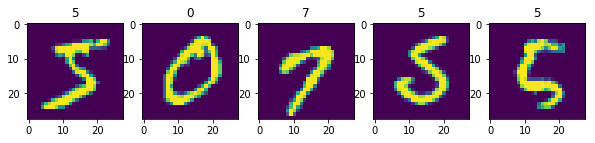

In [2]:
import gzip
import struct
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def read_gz(filename):
    with gzip.open(filename) as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        print("Found datastructure of shape", shape)
        return np.fromstring(f.read(), dtype=np.uint8).reshape(shape)

def plot_mnist(images, labels):
    N = len(labels)
    fig, ax = plt.subplots(ncols=N, figsize=(2*N, 2))
    for i in range(N):
        ax[i].imshow(images[i])
        ax[i].set_title(str(labels[i]))
    plt.show()

pwd = "/home/aleksejs/Downloads/"
train_images = read_gz(pwd + "train-images-idx3-ubyte.gz")
train_labels = read_gz(pwd + "train-labels-idx1-ubyte.gz")
test_images = read_gz(pwd + "t10k-images-idx3-ubyte.gz")
test_labels = read_gz(pwd + "t10k-labels-idx1-ubyte.gz")

select_images = [0,1, 15, 138, 2000]
plot_mnist(train_images[select_images], train_labels[select_images])

# Using Linear Classifier + PCA

Ok, let's train a linear classifier. We will train a classifier of the form

$$y = Ux$$

where $x$ is the image vector, $y$ is the digit, and $U$ is the map between them. The loss function will be defined as

$$L = \sum_i |y_i - Ux_i|^2$$

We can solve the optimization problem exactly by taking the derivative with respect to $U$

$$\partial_U L = -2 \sum_i (y_i - Ux_i)x_i^T = 0$$

So the optimal $U$ is

$$U = A^{-1} B$$

where $A = \sum_i x_i x_i^T$ and $B = \sum_i y_i x_i^T$

In [6]:
N_DIGIT = 10

def least_squares(data, labels, verbose=False):
    nData, nPixel = data.shape
    
    A = np.zeros((nPixel, nPixel))
    B = np.zeros((nPixel, N_DIGIT))
    for i in range(nData):
        if (i % 1000 == 0) and verbose:
            print(i)
        
        y = np.zeros(N_DIGIT)
        y[labels[i]] = 1

        A += np.outer(data[i], data[i])
        B += np.outer(data[i], y)

    return A / nData, B / nData

In [7]:
print("This operation will take time, wait...")
PIXEL_SHAPE = train_images.shape[1:]
N_PIXEL = np.prod(PIXEL_SHAPE)
N_DATA_TRAIN = train_images.shape[0]
N_DATA_TEST = test_images.shape[0]

A, B = least_squares(train_images.reshape(N_DATA_TRAIN, N_PIXEL), train_labels, verbose=True)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000


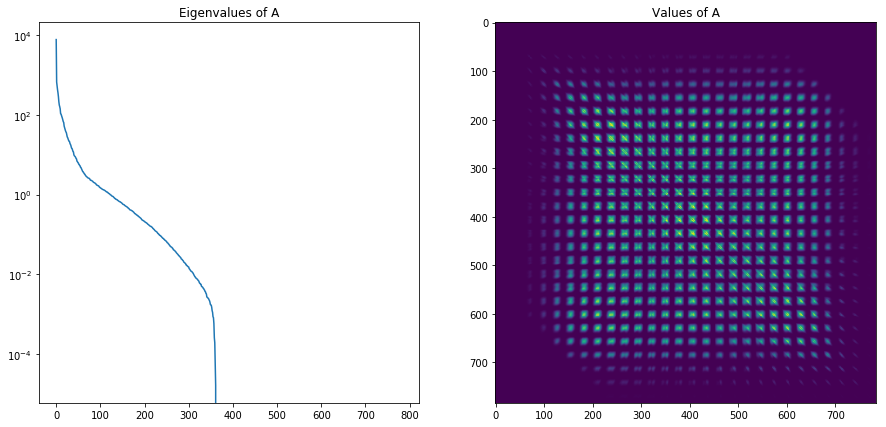

In [11]:
fig, ax = plt.subplots(ncols=2, figsize=(15,7))
ax[0].set_title("Eigenvalues of A")
ax[0].semilogy(np.flip(np.sort(np.linalg.eig(A)[0])))
ax[1].set_title("Values of A")
ax[1].imshow(A)
plt.show()

**FAIL!** The matrix is singular. This is because the there are too many pixels that do essentially the same thing, so there is no unique way to do a least squares fit. Let's do some dimensionality reduction first

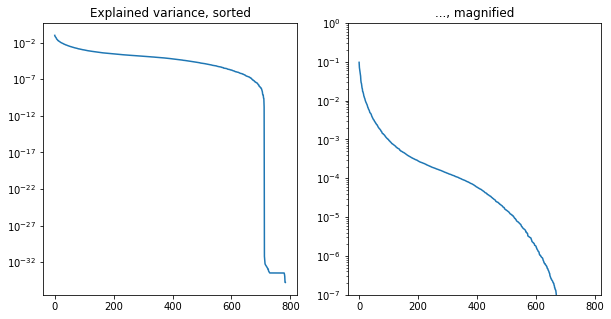

For threshold 0.001 the number of informative PCA are 100


In [25]:
# Perform PCA
pca = PCA()
data_pca_training = pca.fit_transform(train_images.reshape(N_DATA_TRAIN, N_PIXEL))

fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
ax[0].set_title("Explained variance, sorted")
ax[1].set_title("..., magnified")
ax[0].semilogy(pca.explained_variance_ratio_)
ax[1].semilogy(pca.explained_variance_ratio_)
ax[1].set_ylim([1.0e-7, 1.0])
plt.show()

# Apply threshold based on explained variance
THRESHOLD = 1.0e-3
selected_pca = pca.explained_variance_ratio_ > THRESHOLD
N_PCA_SELECTED = np.sum(selected_pca)
print("For threshold", THRESHOLD, "the number of informative PCA are", N_PCA_SELECTED)
data_pca_training_selected = data_pca_training[:, selected_pca]

# Perform selection also for the testing data set
data_pca_testing = pca.transform(test_images.reshape(N_DATA_TEST, N_PIXEL))
data_pca_testing_selected = data_pca_testing[:, selected_pca]

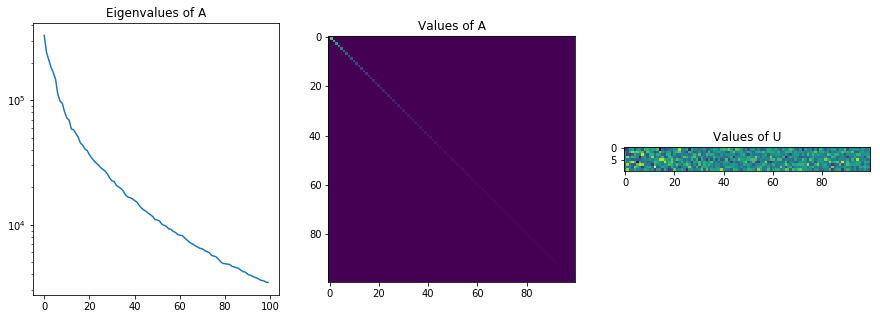

In [26]:
# Redo Least-Squares using only PCA
A, B = least_squares(data_pca_training_selected, train_labels, verbose=False)
U = np.linalg.inv(A).dot(B).transpose()

fig, ax = plt.subplots(ncols=3, figsize=(15,5))
ax[0].set_title("Eigenvalues of A")
ax[0].semilogy(np.flip(np.sort(np.linalg.eig(A)[0])))
ax[1].set_title("Values of A")
ax[1].imshow(A)
ax[2].set_title("Values of U")
ax[2].imshow(U)
plt.show()

Now we can see how well does the classifier predict the labels for training and for testing data. We can calculate the predicted values
$$\hat{y} = Ux$$
Then just take the value that is closest to 1

$$\mathrm{digit} = \mathrm{argmin} |\hat{y} - 1|$$

In [27]:
############################
#  Testing Accuracy
############################
def predict(img, U):
    return np.argmin(np.abs(U.dot(img) - 1))

training_predictions = [predict(data_pca_training_selected[i], U) == train_labels[i] for i in range(N_DATA_TRAIN)]
testing_predictions = [predict(data_pca_testing_selected[i], U) == test_labels[i] for i in range(N_DATA_TEST)]

print("Accuracy on training dataset is:", np.sum(training_predictions) / N_DATA_TRAIN)
print("Accuracy on testing dataset is:", np.sum(testing_predictions) / N_DATA_TEST)

Accuracy on training dataset is: 0.8533666666666667
Accuracy on testing dataset is: 0.8627


Ok, so we get 85% accuracy on both training and testing, that's pretty good. Most naive classifier LeCun used had 88% accuracy, but it is possible to go up to 99.5% with more fancy methods, apparently.

# Using SGD

1. Initialize U randomly
2. Show 1 image at a time
3. Update U usin gradient descent (for some positive learning rate $\zeta$)

$$\Delta U = - \zeta \partial_U L = \zeta \sum_i (y_i - Ux_i)x_i^T$$

**Conclusions**:
* Much simpler than PCA, but also much worse - only 65% accuracy
* Presenting images randomly is much better than presenting one image several times in a row - not sure why.
* Highly sensitive to learning rate - explodes if too large, does not learn at all if too small. Good learning rate within 1 order of magnitude

2034.0722701025154


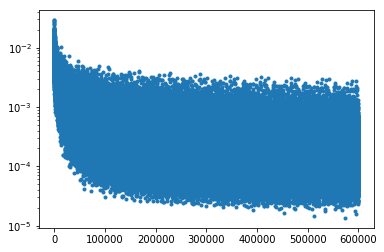

In [58]:
U_SGD = np.random.uniform(-1, 1, N_DIGIT*N_PIXEL).reshape((N_DIGIT, N_PIXEL))
U_SGD /= np.linalg.norm(U_SGD)

zeta = 0.0000001
N_REPS = N_DATA_TRAIN*10
DU_ARR = np.zeros(N_REPS)
for i in range(N_REPS):
    idx = i % N_DATA_TRAIN #np.random.randint(0, N_DATA_TRAIN)
    x = train_images[idx].flatten()
    y = np.zeros(N_DIGIT)
    y[train_labels[idx]] = 1
    
    DU = zeta*np.outer(y - U_SGD.dot(x), x)
    U_SGD += DU
    DU_ARR[i] = np.linalg.norm(DU)
    
print(np.linalg.norm(train_images[idx].flatten()))
    
plt.figure()
plt.semilogy(DU_ARR, '.')
plt.show()

In [59]:
training_predictions = [predict(train_images[i].flatten(), U_SGD) == train_labels[i] for i in range(N_DATA_TRAIN)]
testing_predictions = [predict(test_images[i].flatten(), U_SGD) == test_labels[i] for i in range(N_DATA_TEST)]

print("Accuracy on training dataset is:", np.sum(training_predictions) / N_DATA_TRAIN)
print("Accuracy on testing dataset is:", np.sum(testing_predictions) / N_DATA_TEST)

Accuracy on training dataset is: 0.6830833333333334
Accuracy on testing dataset is: 0.6799
